# RNN Activity: Predicting the stock market
![](https://imgs.xkcd.com/comics/marketwatch.png)

Note: I do not recommend making any kind of financial decisions based on RNNs.

## Setup
To fetch the data, we'll need the `yfinance` package. Activate your virtual environment, then run `pip install yfinance`.

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

2024-03-05 19:45:39.395163: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 19:45:39.396586: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 19:45:39.418907: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 19:45:39.418935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 19:45:39.419581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

[*********************100%%**********************]  1 of 1 completed


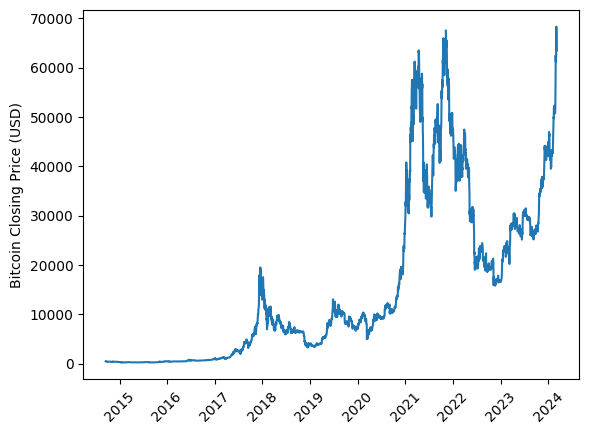

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
# feel free to play around with different ticker values
ticker = "BTC-USD"
description = "Bitcoin"

# get the data for the last 10 years. This is daily data by default, so it's not actually that much.
data = yf.download(ticker, period="10y")

import matplotlib.pyplot as plt

plt.plot(data['Close'])
plt.ylabel(f'{description} Closing Price (USD)')
plt.xticks(rotation=45)
plt.show()

data.head()

## Split the data into training and testing sets
Pandas is pretty smart with dates, so we can use the date as an index. Let's keep 2023 as our test set and choose 2022 as validation.

In [4]:
train_val = '2021-12-31'
val_test = '2022-12-31'

train = data['Close'][:train_val].values
val = data['Close'][train_val:val_test].values
test = data['Close'][val_test:].values

In [5]:
# And prepare for RNN
window = 7

# try using the last 7 days as input to predict the next day
def to_ds(data, input_width, batch_size=32):
    input_data = data[:-input_width]
    targets = data[input_width:]
    return tf.keras.utils.timeseries_dataset_from_array(
        input_data, 
        targets, 
        sequence_length=input_width,
        batch_size=batch_size)

train_ds = to_ds(train, window)
val_ds = to_ds(val, window)
test_ds = to_ds(test, window)

In [6]:
# Start with a single layer RNN
simple_RNN = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(10, input_shape=[None, 1], activation='relu'),
    tf.keras.layers.Dense(1),
])

metrics = [
    tf.keras.metrics.MeanAbsoluteError(),
]

simple_RNN.compile(optimizer='adam', loss='mse', metrics=metrics)
history = simple_RNN.fit(train_ds, validation_data=val_ds, epochs=100)

Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 339432608.0000 - mean_absolute_error: 11028.8008 - val_loss: 685874944.0000 - val_mean_absolute_error: 24660.2656
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 177604432.0000 - mean_absolute_error: 7677.6021 - val_loss: 366866656.0000 - val_mean_absolute_error: 18024.3457
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 61635432.0000 - mean_absolute_error: 4680.8813 - val_loss: 70012984.0000 - val_mean_absolute_error: 7769.3677
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 2194923.0000 - mean_absolute_error: 722.4139 - val_loss: 2016361.1250 - val_mean_absolute_error: 949.0396
Epoch 5/100
83/83 [==============================] - 0s 2ms/step - loss: 1147032.6250 - mean_absolute_error: 463.5836 - val_loss: 1705777.8750 - val_mean_absolute_error: 871.6732
Epoch 6/100
83/83 [==============================] - 0s 2ms/step - loss: 1067504.5000 

(0.0, 2000.0)

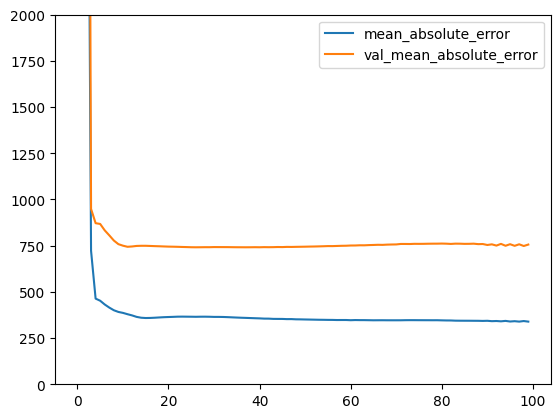

In [7]:
# plot the training curve
pd.DataFrame(history.history)[['mean_absolute_error', 'val_mean_absolute_error']].plot()
plt.ylim(0, 2000)

14/14 [==============================] - 0s 1ms/step


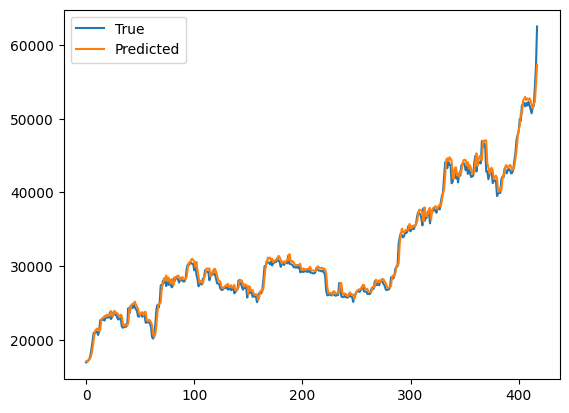

In [9]:
# Predict on the test set and see how well it does
predictions = simple_RNN.predict(test_ds)

# Note: pandas is smart enough to show the dates, so getting .values allows
# us to align with the predictions a bit better
plt.plot(test[window:-window+1], label='True')
plt.plot(predictions.flatten(), label='Predicted')
plt.legend()

## Exercises and Questions
1. Can you improve the model? Try playing around with layers, units, activation functions, etc
2. Why does it look okay when you overlay the predictions, but the MAE is so high?
3. Can you modify the model to try to predict the **direction** of the stock instead of the price (i.e. up or down)?
4. Can you modify the model to make it predict X days in the future instead of just 1?

## Messing with sequence to vector
The following code is an attempt to predict a vector (e.g. the next week) rather than just the next single day.

In [10]:
window = 7
output_width = 7

# Functions blatantly copied from https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=7, ahead=7, batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

train_seq = to_seq2seq_dataset(train, window, output_width)
val_seq = to_seq2seq_dataset(val, window, output_width)
test_seq = to_seq2seq_dataset(test, window, output_width)

In [11]:
# try a deeper model
seq_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(16, input_shape=[None, 1], return_sequences=True, activation='relu'),
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1], return_sequences=True, activation='relu'),
    tf.keras.layers.Dense(output_width)
])

cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
seq_model.compile(loss='huber', optimizer='adam', metrics=metrics)
seq_model.summary()
history = seq_model.fit(train_seq, validation_data=val_seq, epochs=100, callbacks=[cb])

pd.DataFrame(history.history)[['mean_absolute_error', 'val_mean_absolute_error']].plot()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 16)          288       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          1568      
                                                                 
 dense_1 (Dense)             (None, None, 7)           231       
                                                                 
Total params: 2087 (8.15 KB)
Trainable params: 2087 (8.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
83/83 [==============================] - 1s 5ms/step - loss: 3238.1736 - mean_absolute_error: 3238.6733 - val_loss: 5604.9556 - val_mean_absolute_error: 5605.4541
Epoch 2/100
83/83 [==============================] - 0s 3ms/step - loss: 1664.4840 - mean_absolute_error: 1664.

1/1 [==============================] - 0s 11ms/step


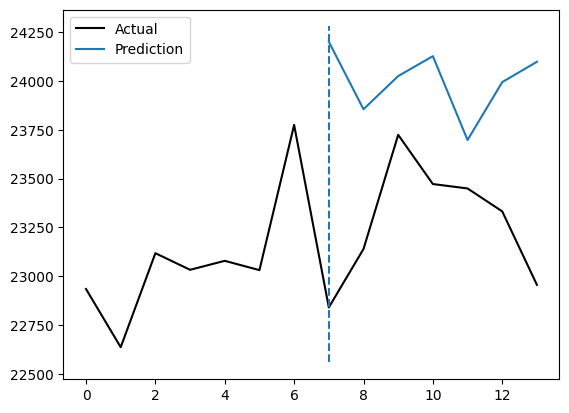

In [38]:
# Predict on the test set and see how well it does
overall_mae = seq_model.evaluate(test_seq)

predict_day = 30
prior_days = window
seq_pred = seq_model.predict(test[predict_day - prior_days:predict_day].reshape(1, -1, 1))

# plot the predictions at the last day
plt.plot(test[predict_day - prior_days:predict_day+window], 'k', label='Actual')
plt.plot(np.arange(prior_days, prior_days + output_width), seq_pred.squeeze()[-1,:], label='Prediction')
yrange = plt.ylim()
plt.vlines(prior_days, yrange[0], yrange[1], linestyles='dashed')
plt.legend()
plt.show()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, None, 16)          1152      
                                                                 
 lstm_7 (LSTM)               (None, None, 16)          2112      
                                                                 
 dense_11 (Dense)            (None, None, 7)           119       
                                                                 
Total params: 3383 (13.21 KB)
Trainable params: 3383 (13.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
83/83 [==============================] - 2s 7ms/step - loss: 8347.6260 - mean_absolute_error: 11284.0664 - val_loss: 19674.9141 - val_mean_absolute_error: 19675.4160
Epoch 2/100
83/83 [==============================] - 0s 4ms/step - loss: 5321.0522 - mean_absolute_error:

<Axes: >

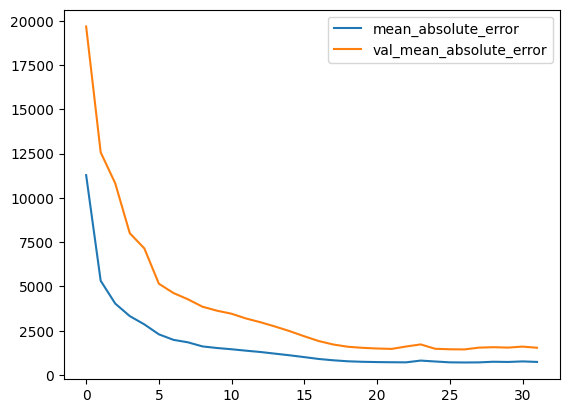

In [33]:
# Try an LSTM model
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, input_shape=[None, 1], return_sequences=True, activation='relu'),
    tf.keras.layers.LSTM(16, input_shape=[None, 1], return_sequences=True, activation='relu'),
    tf.keras.layers.Dense(output_width)
])

lstm_model.compile(loss='huber', optimizer='adam', metrics=metrics)
lstm_model.summary()
history = lstm_model.fit(train_seq, validation_data=val_seq, epochs=100, callbacks=[cb])

pd.DataFrame(history.history)[['mean_absolute_error', 'val_mean_absolute_error']].plot()

1/1 [==============================] - 0s 13ms/step


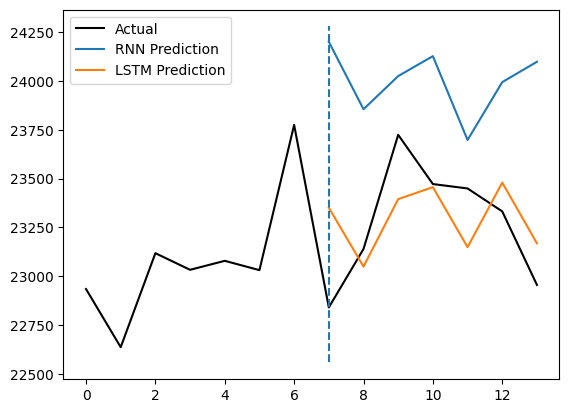

In [39]:
# Predict on the test set and see how well it does
overall_mae = lstm_model.evaluate(test_seq)
predict_day = 30
prior_days = window
lstm_pred = lstm_model.predict(test[predict_day - prior_days:predict_day].reshape(1, -1, 1))

# plot the predictions at the last day
plt.plot(test[predict_day - prior_days:predict_day+window], 'k', label='Actual')
plt.plot(np.arange(prior_days, prior_days + output_width), seq_pred.squeeze()[-1,:], label='RNN Prediction')
plt.plot(np.arange(prior_days, prior_days + output_width), lstm_pred.squeeze()[-1,:], label='LSTM Prediction')
yrange = plt.ylim()
plt.vlines(prior_days, yrange[0], yrange[1], linestyles='dashed')
plt.legend()
plt.show()